<a href="https://colab.research.google.com/github/ShivaKondapalli/Invariance/blob/master/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim import lr_scheduler
from torch import optim
from torchvision import datasets
import torchvision
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
torch.set_printoptions(precision=10)

In [0]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('Bummer!  Training on CPU ...')
else:
    print('You are good to go!  Training on GPU ...')

You are good to go!  Training on GPU ...


In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
}

In [0]:
trainset = datasets.MNIST('MNIST_data', download=True, train=True,
                                 transform=data_transforms['train'])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)


testset = datasets.MNIST('MNIST_data', download=True, train=False, transform=data_transforms['valid'])
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


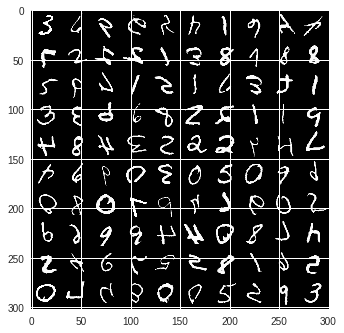

In [0]:
imgs, lbls = next(iter(trainloader))

grid = torchvision.utils.make_grid(imgs, nrow=10)

plt.imshow(np.transpose(grid, (1, 2,0)))

In [0]:
class MyConv(nn.Module):
    def __init__(self):
        super(MyConv, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
        self.conv2_bn = nn.BatchNorm2d(32)

        self.fc1 = nn.Linear(in_features=32 * 4 * 4, out_features=120)
        self.fc1_bn = nn.BatchNorm1d(120)
        
        self.dropout = nn.Dropout(0.2)

        self.out = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2))
        x = F.relu(F.max_pool2d(self.conv2_bn(self.conv2(x)), kernel_size=2))

        x = x.flatten(start_dim=1)
        
        x = F.relu(self.fc1_bn(self.fc1(x)))
        
        x = self.dropout(x)
        
        x = F.relu(self.out(x))

        return F.log_softmax(x, dim=1)

net = MyConv()
net

MyConv(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=512, out_features=120, bias=True)
  (fc1_bn): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2)
  (out): Linear(in_features=120, out_features=10, bias=True)
)

In [0]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


def validation(model, loader, criterion, device='cuda'):
    val_loss = 0.0
    val_accuracy = 0.0

    for images, labels in loader:
        # images = images.resize_(images.size(0), 784)

        images, labels = images.to(device), labels.to(device)

        output = model.forward(images)
        loss = criterion(output, labels).item()
        probs = torch.exp(output)
        _, preds = probs.max(dim=1)
        equality = (preds == labels)

        val_loss += loss
        val_accuracy += equality.type(torch.FloatTensor).mean()

    return val_loss, val_accuracy

Epoch: 1/15.. training_loss: 1.9138 validation loss: 1.8624  validation accuracy: 0.5541
Epoch: 1/15.. training_loss: 1.4071 validation loss: 1.0924  validation accuracy: 0.7531
Epoch: 1/15.. training_loss: 1.0562 validation loss: 0.8635  validation accuracy: 0.8130
Epoch: 1/15.. training_loss: 0.7816 validation loss: 0.7132  validation accuracy: 0.8227
Epoch: 1/15.. training_loss: 0.6338 validation loss: 0.5208  validation accuracy: 0.8646
Epoch: 1/15.. training_loss: 0.5262 validation loss: 0.4798  validation accuracy: 0.8696
Epoch: 1/15.. training_loss: 0.4823 validation loss: 0.4196  validation accuracy: 0.8864
Epoch: 1/15.. training_loss: 0.4489 validation loss: 0.3896  validation accuracy: 0.8990
Epoch: 1/15.. training_loss: 0.3968 validation loss: 0.3476  validation accuracy: 0.9021
Epoch: 1/15.. training_loss: 0.3723 validation loss: 0.3496  validation accuracy: 0.9006
Epoch: 1/15.. training_loss: 0.3416 validation loss: 0.2921  validation accuracy: 0.9107
Epoch: 1/15.. trainin

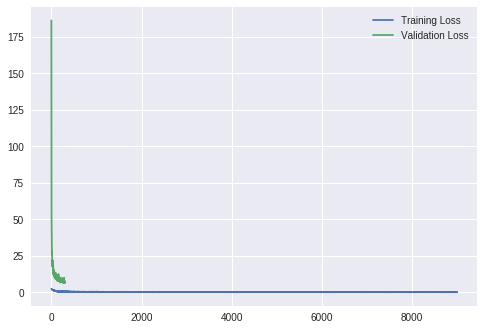

In [0]:
# bells and whistles for setting up odel training

print_every = 30
steps = 0
num_epochs = 15
running_loss = 0

train_losses = []
test_losses = []

for epoch in range(num_epochs):
  
  for images, labels in trainloader:
    
    steps += 1
    images, labels = images.cuda(), labels.cuda()
    
    net.cuda()
    
    net.train()
    
    optimizer.zero_grad()
    
    logps = net.forward(images)
    
    loss = criterion(logps, labels)
    train_losses.append(loss)
    
    loss.backward()
    
    optimizer.step()
    
    running_loss += loss.item()
    
    if steps % print_every == 0:
      
      net.eval()
      
      with torch.no_grad():
        
        test_loss, test_accuracy = validation(net, testloader, criterion)
        
        test_losses.append(test_loss)
        
        print("Epoch: {}/{}..".format(epoch + 1, num_epochs),
              "training_loss: {:.4f}".format(running_loss / print_every),
              "validation loss: {:.4f} ".format(test_loss / len(testloader)),
              "validation accuracy: {:.4f}".format(test_accuracy / len(testloader)))
        
        running_loss = 0
        
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend(frameon=False)
plt.show()

Model Prediction: zero


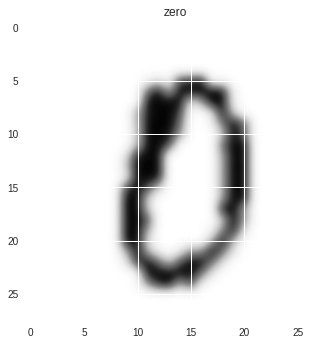

In [0]:
class_label_map = {0: "zero", 1: "One", 2: "Two", 3: "Three", 4: "Four", 5: "Five", 6: "Six", 7: "Seven", 8: "Eight", 9: "Nine" }
 

def predict(loader, model, key):
  
  image, labels = next(iter(loader))
  img, lbl = image[key], labels[key]
  
  lbl = lbl.item()
  
  plt.imshow(transforms.ToPILImage()(img), interpolation="bicubic")
  plt.title(class_label_map[lbl])
  
  model.eval()
  model.cpu()
  
  out = net.forward(img.unsqueeze_(0))
  ps = torch.exp(out)
  
  ps, pred = ps.max(dim=1)
  pred = pred.item()
  predicted_label = class_label_map[pred]
  
    
  return predicted_label

pred_label = predict(loader=testloader, model=net, key=55)
print(f'Model Prediction: {pred_label}')